In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Iterable
from scipy import optimize, stats, signal

In [2]:
def cast_variables(pH, pKa):
    """
    Ensure pH and pKa have correct types and shapes
    """
    
    if not isinstance(pH, Iterable):
        pH = [pH]
    
    pH = np.array(pH)
    pKa = np.array(pKa)
    
    return pH, pKa

In [3]:
def monom(i, pH, pKa):
    pH, pKa = cast_variables(pH, pKa)
    H = np.power(10., -pH)
    Ka = np.power(10., -pKa)
    n = len(pKa)
    return np.power(H, i) * np.prod(Ka[:(n - i)])

In [4]:
def polynom(pH, pKa):
    pH, pKa = cast_variables(pH, pKa)
    n = len(pKa)
    return np.sum([monom(i, pH, pKa) for i in range(n + 1)], axis=0)

In [5]:
def alpha(i, pH, pKa):
    """
    Compute i-th partition function
    """
    return monom(i, pH, pKa) / polynom(pH, pKa)

In [6]:
def alphas(pH, pKa):
    """
    Compute all partition functions
    """
    
    pH, pKa = cast_variables(pH, pKa)
    
    n = pKa.size + 1
    a = np.full((pH.size, n), np.nan)
    
    for i in range(n):
        a[:, i] = alpha(n - i - 1, pH, pKa)
    
    if not np.allclose(np.sum(a, axis=1), 1.):
        raise ValueError("Partition functions does not sum up to unity")
    
    return a

In [7]:
def system(C, pKa, Ct, Na):
    """
    System of equation to solve the pH of the mixture.
    Concentration C is n + 2 vector structured as follow: (H_nA, ..., A^n-, H^+)
    Ct is a constant for total concentration of species H_nA, ..., A^n-
    Na is a constant for total concentration of counter ion of ionised species H_n-1A^-, ..., A^n-
    
    There are n equilibria constants of the form:
    
    Ka_n = [H_n-1A^-] * [H^+] / [H_nA] 
    
    Mass balance:
    
    Ct = [H_nA] +  ... + [A^n-]
    
    Charge balance:
    
    [H^+] + [Na^+] = 0 * [H_nA] +  ... + n * [A^n-]

    Which provides n + 2 equations to solve n + 2 concentrations.
    """
    
    pKa = np.array(pKa)
    Ka = np.power(10., -pKa)
    
    return np.array([
        # Acid/Base Equilibria:
        ((C[i + 1] * C[-1]) - C[i] * Ka[i]) * 1e7
        for i in range(len(Ka))
    ] + [
        # Charge Balance:
        np.sum(np.arange(len(Ka) + 1) * C[:-1]) - C[-1] - Na,
        # Mass Balance:
        np.sum(C[:-1]) - Ct
    ])

In [8]:
def solve(C0, pKa, pH0=7.):
    """
    Solve the system for the given initial concentrations (including initial pH) and pKa.
    """
    
    H0 = np.power(10., -float(pH0))
    C0 = np.array(list(C0) + [H0])
    
    Ct = np.sum(C0[:-1])
    Na = np.sum(np.arange(C0[:-1].size) * C0[:-1])
    
    sol, info, code, message = optimize.fsolve(
        system,
        x0=[1.] * len(C0),
        args=(pKa, Ct, Na),
        full_output=True,
        maxfev=50000
    )
    
    if code != 1:
        raise ValueError("Solution not found: %s" % message)
    
    H = sol[-1]
    pH = -np.log10(H)
    a = alphas(pH, pKa).squeeze()
    C = a * Ct
    
    return {
        "C": C,
        "alphas": a,
        "H": H,
        "pH": pH,
    }

In [9]:
def plot(pKa, sol=None):
    """
    Plot partition curves and aditionnaly a solution if provided
    """
    n = len(pKa)
    pH = np.linspace(0, 14, 200)
    As = alphas(pH, pKa)
    labels = [r"Partition $\alpha_{%d}$" % i for i in reversed(range(n + 1))]
    
    fig, axe = plt.subplots()
    axe.plot(pH, As)
    
    if sol:
        axe.axvline(sol["pH"], linestyle="--", color="black")
        sols = []
        for i, a in enumerate(sol["alphas"]):
            axe.scatter([sol["pH"]], [a])
            sols.append(r"$\alpha_{%d} =$ %.3g" % ((n-i), a))
        labels += ["$pH =$ %.2f" % sol["pH"]] + sols
    
    axe.set_title("Acid/Base Partitions: $pKa =$ %s" % pKa)
    axe.set_xlabel(r"Proton Concentration, $pH$")
    axe.set_ylabel(r"Partition Functions, $\alpha_i$")
    axe.legend(labels, bbox_to_anchor=(1, 1))
    axe.grid()
    
    return axe

{'C': array([1.70165471e-17, 7.56824621e-07, 2.99998486e-01, 9.00000757e-01]),
 'alphas': array([1.41804560e-17, 6.30687185e-07, 2.49998739e-01, 7.50000631e-01]),
 'H': 1.5991020824462138e-13,
 'pH': 12.796123811158091}

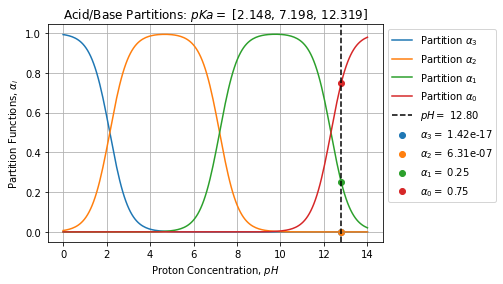

In [10]:
pKa = [2.148, 7.198, 12.319]
C0 = [0.0, 0.1, .1, 1.]
sol = solve(C0, pKa)
axe = plot(pKa, sol)
sol